# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ydata_profiling
from statsmodels.tsa.seasonal import seasonal_decompose


### 1b. Load the data
Call the variable `cigData`. 

In [212]:
cigData = pd.read_csv("/Users/marciobernardo/Documents/Springboard/Cowboys&CigrettesCaseStudy/CowboyCigsData.csv")


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [213]:
cigData.head(10)

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121
5,5,1949-06,1000135
6,6,1949-07,1000148
7,7,1949-08,1000148
8,8,1949-09,1000136
9,9,1949-10,1000119


In [214]:
cigData.tail(10)

,Unnamed: 0,Time,#CigSales
134,134,1960-03,1000419
135,135,1960-04,1000461
136,136,1960-05,1000472
137,137,1960-06,1000535
138,138,1960-07,1000622
139,139,1960-08,1000606
140,140,1960-09,1000508
141,141,1960-10,1000461
142,142,1960-11,1000390
143,143,1960-12,1000432


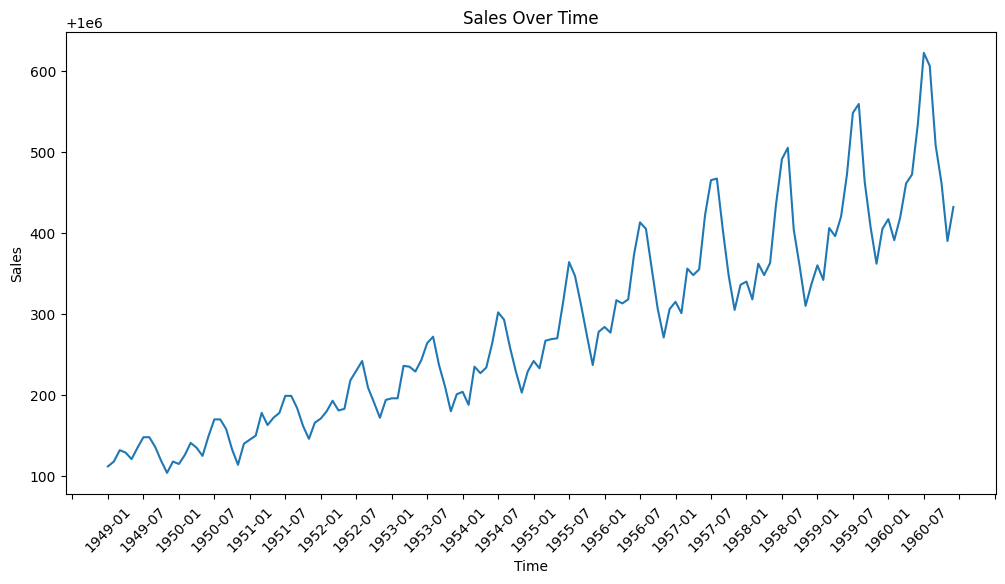

In [215]:
plt.figure(figsize=(12, 6))  # Set the figure size (width, height)

# Use Seaborn to create a line plot
sns.lineplot(data=cigData, x='Time', y='#CigSales')

# Set labels for the x and y axes
plt.xlabel('Time')
plt.ylabel('Sales')

# Optionally, set a title for the plot
plt.title('Sales Over Time')

plt.xticks(rotation=45)  # Rotate labels by 45 degrees
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))  # Set the number of major ticks


# Display the plot
plt.show()

The cigData set represents monthly cigarette sales from January 1949 to December 1960, totaling 144 records. The time chart clearly illustrates that the time series exhibits seasonality and an upward trend.

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [216]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


The data set has 3 columns and 144 records. However the first column called 'Unnamed: 0' is only an index. This column doesn't contain any usefull data since pandas dataframes already has an index.

Let's check out the data types of our columns.

In [217]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Columns 'Unnamed: 0' and '#CigSales' are int64 type of data integer values. Time is an object, it should be converted to a datetime data.

Check whether there are any null values. 

In [218]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


There os no null values in the data set.

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [219]:
cigData.drop('Unnamed: 0', axis=1, inplace = True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [220]:
cigData.rename(columns={'Time':'Month'},inplace=True)

Call a head() to check this has worked. 

In [221]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [222]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

cigData.set_index('Month', inplace = True)

In [223]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [224]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [225]:
y.dtypes

dtype('int64')

In [226]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Series name: #CigSales
Non-Null Count  Dtype
--------------  -----
144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


The y pandas series is a int64 data, but more interesting it carried the time index we created above, so it has Month as its index.

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [227]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

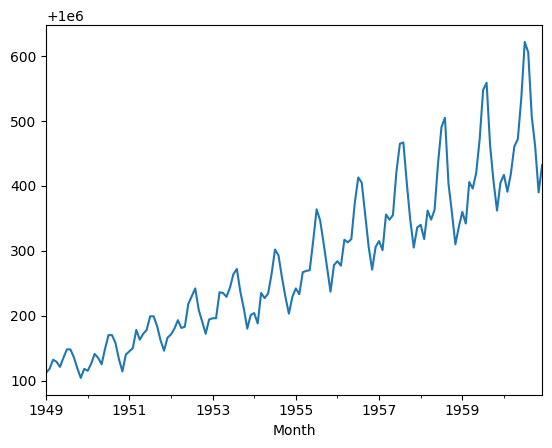

In [228]:
# Since the data has a pandas time series object, you can simply plot it using pandas plot.
y.plot();

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

The cigData time series show a multiplicative seasonality.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

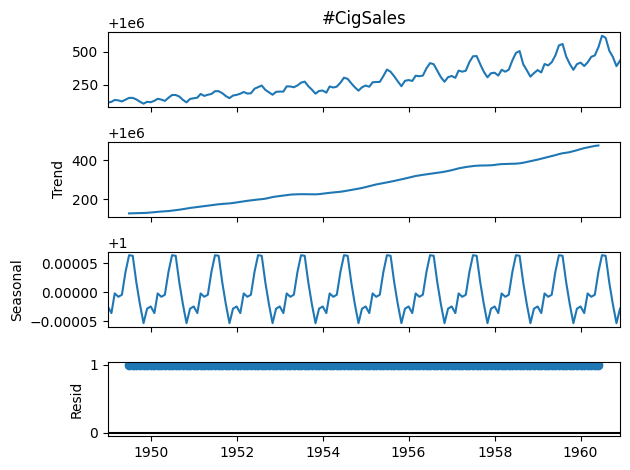

In [229]:
decomposed_data = seasonal_decompose(y,model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 

decomposed_data.plot();

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [230]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import kpss

kpss(y)

(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

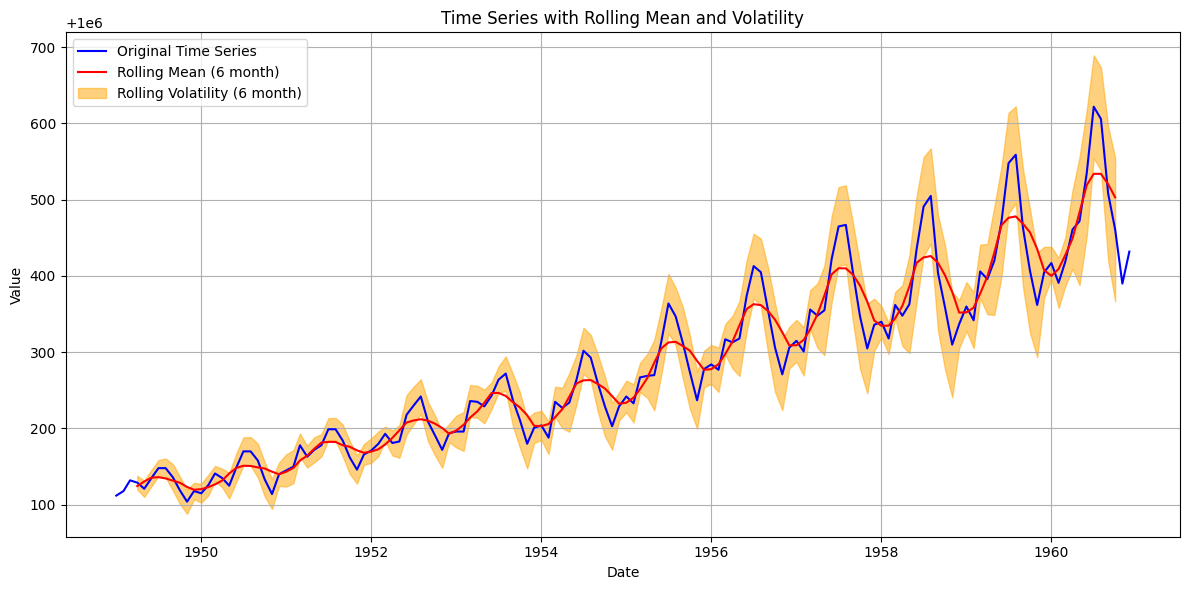

In [231]:

# Compute rolling mean and rolling standard deviation
window_size = 6  # Calculating the 6 month rolling
rolling_mean = y.rolling(window=window_size, center = True).mean()
rolling_std = y.rolling(window=window_size, center = True).std()

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Original Time Series', color='blue')

# Plot the rolling mean
plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window_size} month)', color='red')

# Plot the rolling standard deviation (volatility)
plt.fill_between(rolling_std.index, y - rolling_std, y + rolling_std, color='orange', alpha=0.5, label=f'Rolling Volatility ({window_size} month)')

# Customize the plot
plt.title('Time Series with Rolling Mean and Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 


When you plot this, you can see how the variance in our data now remains contant over time.

In [232]:

log_y = np.log(y)

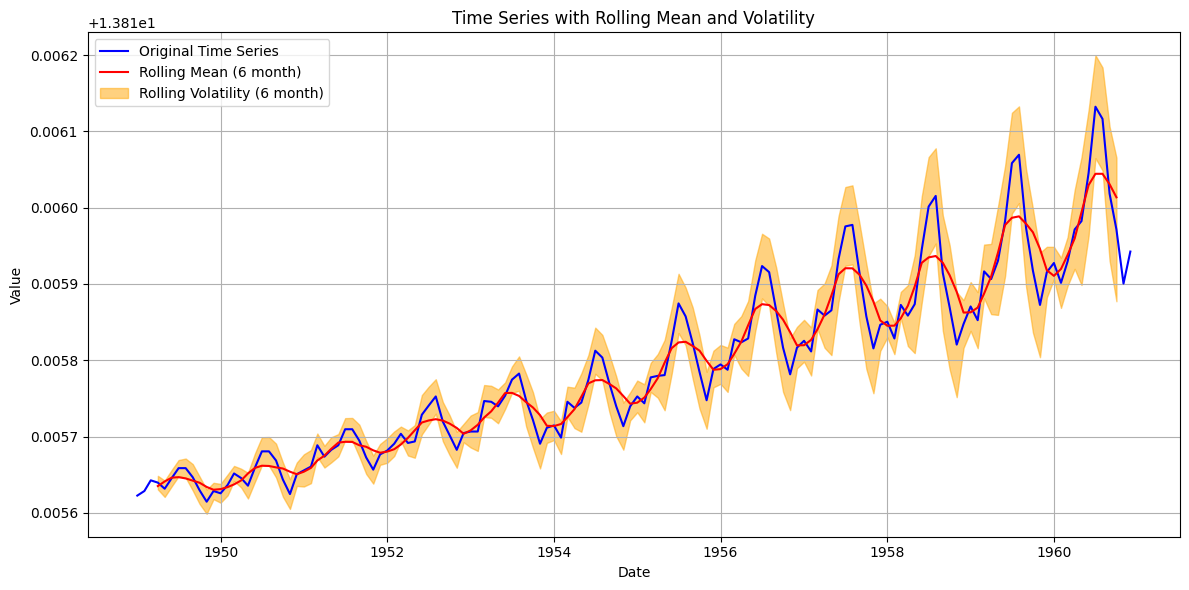

In [240]:

# Compute rolling mean and rolling standard deviation
window_size = 6  # Calculating the 6 month rolling
rolling_mean = log_y.rolling(window=window_size, center = True).mean()
rolling_std = log_y.rolling(window=window_size, center = True).std()

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(log_y.index, log_y, label='Original Time Series', color='blue')

# Plot the rolling mean
plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window_size} month)', color='red')

# Plot the rolling standard deviation (volatility)
plt.fill_between(rolling_std.index, log_y - rolling_std, log_y + rolling_std, color='orange', alpha=0.5, label=f'Rolling Volatility ({window_size} month)')

# Customize the plot
plt.title('Time Series with Rolling Mean and Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [241]:
dif_log_y = log_y.diff(periods=1)[1:]

In [242]:

dif_log_y.head()

Month
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
1949-06-01    0.000014
Name: #CigSales, dtype: float64

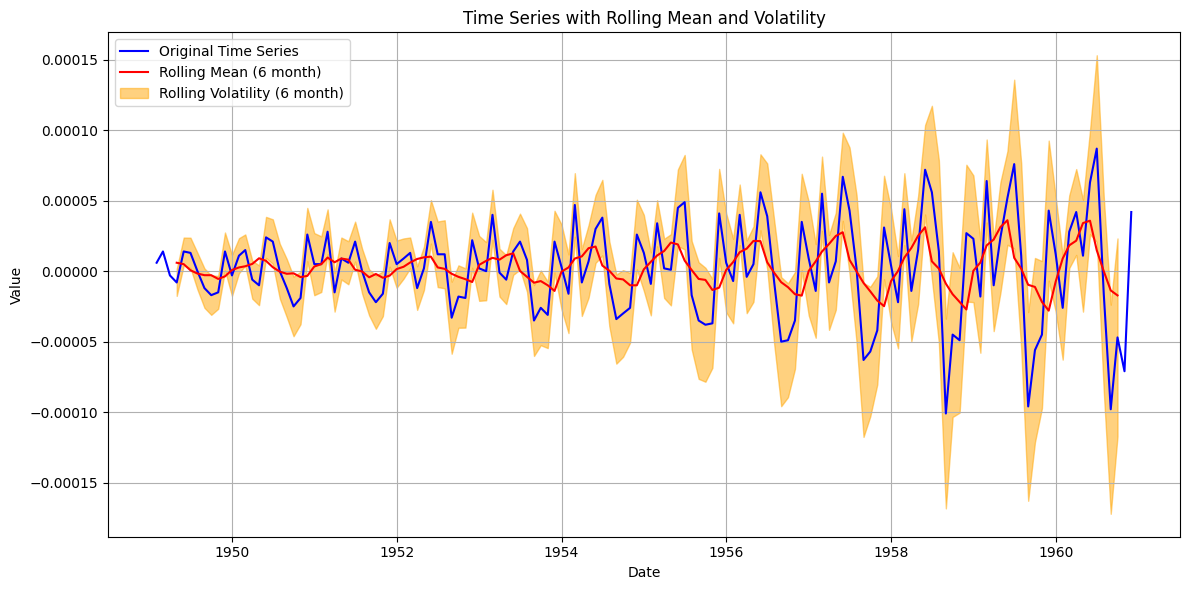

In [243]:

# Compute rolling mean and rolling standard deviation
window_size = 6  # Calculating the 6 month rolling
rolling_mean = dif_log_y.rolling(window=window_size, center = True).mean()
rolling_std = dif_log_y.rolling(window=window_size, center = True).std()

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(dif_log_y.index, dif_log_y, label='Original Time Series', color='blue')

# Plot the rolling mean
plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window_size} month)', color='red')

# Plot the rolling standard deviation (volatility)
plt.fill_between(rolling_std.index, dif_log_y - rolling_std, dif_log_y + rolling_std, color='orange', alpha=0.5, label=f'Rolling Volatility ({window_size} month)')

# Customize the plot
plt.title('Time Series with Rolling Mean and Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [244]:
kpss(dif_log_y)

(0.023897674207570562,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [245]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [246]:
import statsmodels.api as sm

Analysing ACF and PACF graphs

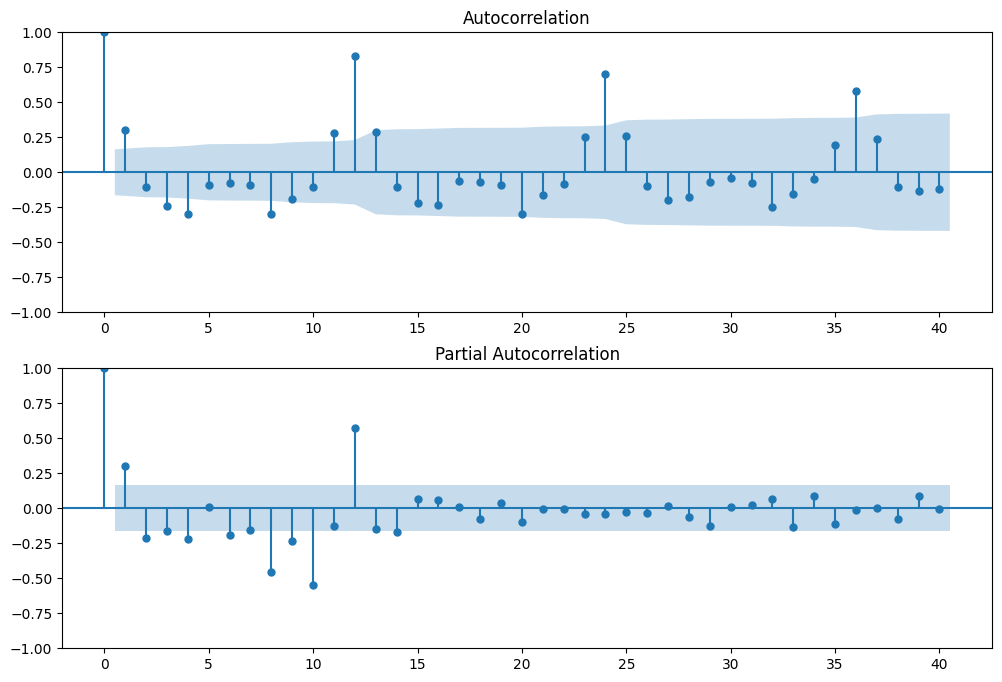

In [247]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif_log_y.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dif_log_y, lags=40, ax=ax2)

ACF graph suggest a significant lag effect for 1 months and 12 months, while PACF show significant lag effect 2 month and 12 also. Therefore a SARIMA model with order 2,0,1,12 should capture the data quite well 

In [248]:
# arma_model_201

arma_201 = ARIMA(dif_log_y,order = (2,0,1)).fit() 

print(arma_201.summary())

                               SARIMAX Results                                
Dep. Variable:              #CigSales   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1287.929
Date:                Fri, 08 Sep 2023   AIC                          -2565.858
Time:                        00:27:43   BIC                          -2551.043
Sample:                    02-01-1949   HQIC                         -2559.838
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.354e-06   1.92e-06      0.705      0.481   -2.41e-06    5.12e-06
ar.L1          1.0672   1.88e-11   5.66e+10      0.000       1.067       1.067
ar.L2         -0.4449    2.4e-11  -1.86e+10      0.0

<Axes: xlabel='Month'>

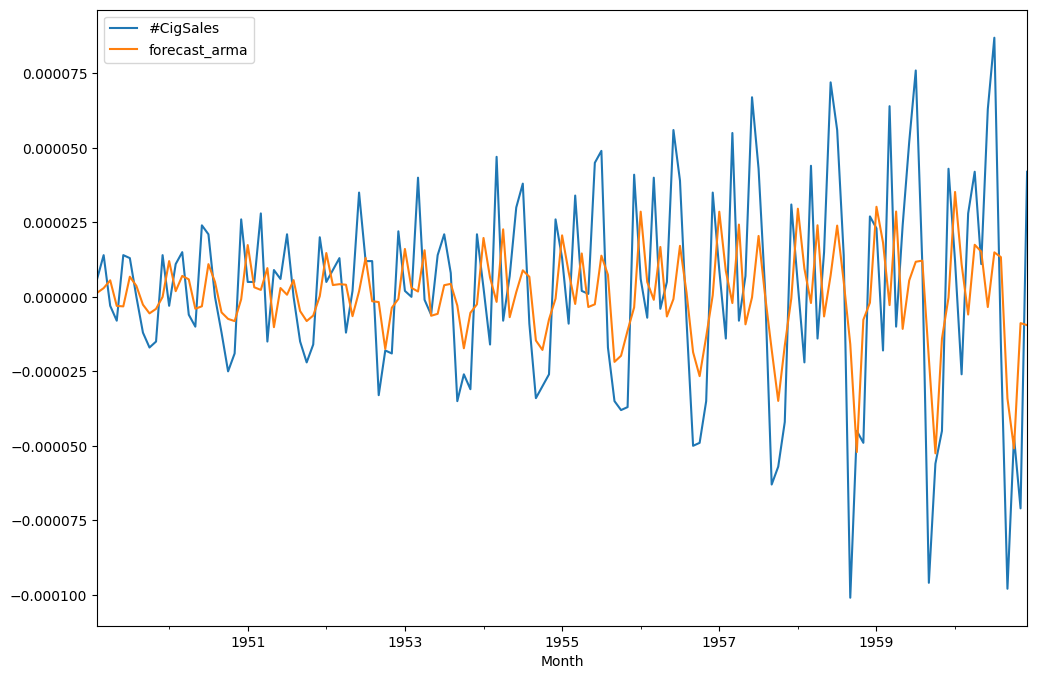

In [296]:
df = pd.DataFrame(dif_log_y)
df['forecast_arma']=arma_201.predict()

df[['#CigSales','forecast_arma']].plot(figsize=(12,8))

In [255]:
# sarma_model_201_11112

sarma_201_12 = SARIMAX(dif_log_y,order = (2,0,1),seasonal_order=(1,1,1,12)).fit(disp=False) 

print(sarma_201_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          #CigSales   No. Observations:                  143
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                1290.811
Date:                            Fri, 08 Sep 2023   AIC                          -2569.622
Time:                                    00:29:30   BIC                          -2552.371
Sample:                                02-01-1949   HQIC                         -2562.613
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -3.606e-10   4.04e-20  -8.93e+09      0.000   -3.61e-10   -3.61e-10
ar.L2       1.372e-11   3.44e-20   

<Axes: xlabel='Month'>

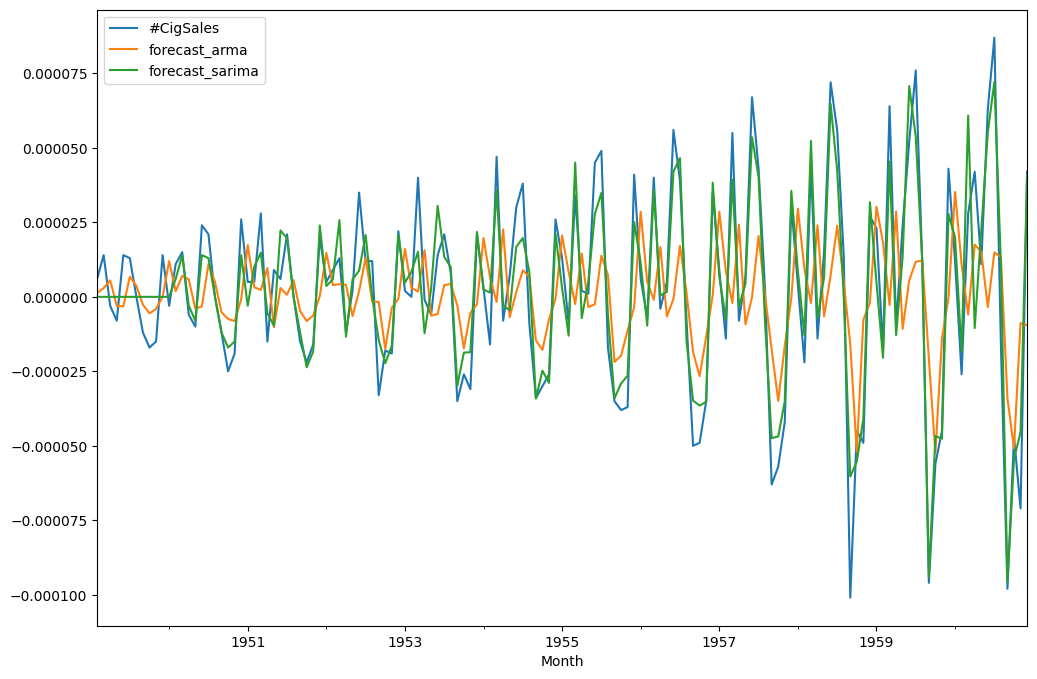

In [297]:
df['forecast_sarima']=sarma_201_12.predict()

df[['#CigSales','forecast_arma','forecast_sarima']].plot(figsize=(12,8))

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1949-02-01 to 1960-12-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   #CigSales        143 non-null    float64
 1   forecast         13 non-null     float64
 2   forecast_sarima  13 non-null     float64
dtypes: float64(3)
memory usage: 8.5 KB


In [257]:
# Calculating the rmse

rsme_arma_201 = mean_squared_error(df.iloc[130:,0],df.iloc[130:,1], squared = False)
rsme_sarma_201_12 = mean_squared_error(df.iloc[130:,0],df.iloc[130:,2], squared = False)

print(f'The rsme of the ARIMA(2,0,1) model is {rsme_arma_201}')
print(f'The rsme of the SARIMA(2,0,1,12) model is {rsme_sarma_201_12}')

The rsme of the ARIMA(2,0,1) model is 5.3311255713256666e-05
The rsme of the SARIMA(2,0,1,12) model is 2.1896808375436443e-05


The Sarima model outperform the Arima model considerably

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [258]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.

def arima_eval(y,p,d,q):
    """
    Takes as imput a series or a columns of a dataframe, and the parameters p,d,q of an ARIMA model and return the rmse of that model. 
    """
    model = ARIMA(y,order = (p,d,q))
    model_fit = model.fit()
    pred_end = len(y) - 1
    pred_start = len(y) - 15
    pred =  model_fit.predict(start=pred_start,end=pred_end,dynamic=True)
    rsme = mean_squared_error(y[pred_start:],pred, squared = False)
  
    return f'The rmse of the ARIMA({p}, {d}, {q}) model is: {rsme}'

In [259]:
model = ARIMA(dif_log_y, order = (2,0,1))
model_fit = model.fit()

In [260]:
# Now, we choose a couple of values to try for each parameter.
arima_eval(dif_log_y,2,0,1)

'The rmse of the ARIMA(2, 0, 1) model is: 4.9583034261093e-05'

In [261]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
for i in range(1,6):
    for j in range(1,6):
        print(arima_eval(dif_log_y,i,0,j))

The rmse of the ARIMA(1, 0, 1) model is: 5.034725802498573e-05
The rmse of the ARIMA(1, 0, 2) model is: 5.037753850947182e-05
The rmse of the ARIMA(1, 0, 3) model is: 6.539700752055204e-05
The rmse of the ARIMA(1, 0, 4) model is: 5.0308019708101796e-05
The rmse of the ARIMA(1, 0, 5) model is: 5.3449759613121586e-05
The rmse of the ARIMA(2, 0, 1) model is: 4.9583034261093e-05
The rmse of the ARIMA(2, 0, 2) model is: 4.9664240258920795e-05
The rmse of the ARIMA(2, 0, 3) model is: 6.645919352755202e-05
The rmse of the ARIMA(2, 0, 4) model is: 5.5524292819700886e-05
The rmse of the ARIMA(2, 0, 5) model is: 5.0607656360194445e-05
The rmse of the ARIMA(3, 0, 1) model is: 4.931546019444873e-05
The rmse of the ARIMA(3, 0, 2) model is: 5.233509241038355e-05
The rmse of the ARIMA(3, 0, 3) model is: 5.216524978314528e-05
The rmse of the ARIMA(3, 0, 4) model is: 5.472718201296052e-05
The rmse of the ARIMA(3, 0, 5) model is: 7.451456725530502e-05
The rmse of the ARIMA(4, 0, 1) model is: 5.195676431

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [307]:
model_arima_211 = ARIMA(dif_log_y, order = (2,0,1))  # our series is already diferentiated in the first order
model_arima_211_fit = model_arima_211.fit()


In [324]:
forecast = model_arima_211_fit.predict(start = 142, end = 156, dynamic = True)
forecast_sarima = sarma_201_12.predict(start = 142, end = 156, dynamic = True)

We can take a look at a summary of the model this library has built around our data.

In [309]:
print(model_arima_211_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              #CigSales   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1287.929
Date:                Fri, 08 Sep 2023   AIC                          -2565.858
Time:                        01:01:48   BIC                          -2551.043
Sample:                    02-01-1949   HQIC                         -2559.838
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.354e-06   1.92e-06      0.705      0.481   -2.41e-06    5.12e-06
ar.L1          1.0672   1.88e-11   5.66e+10      0.000       1.067       1.067
ar.L2         -0.4449    2.4e-11  -1.86e+10      0.0

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

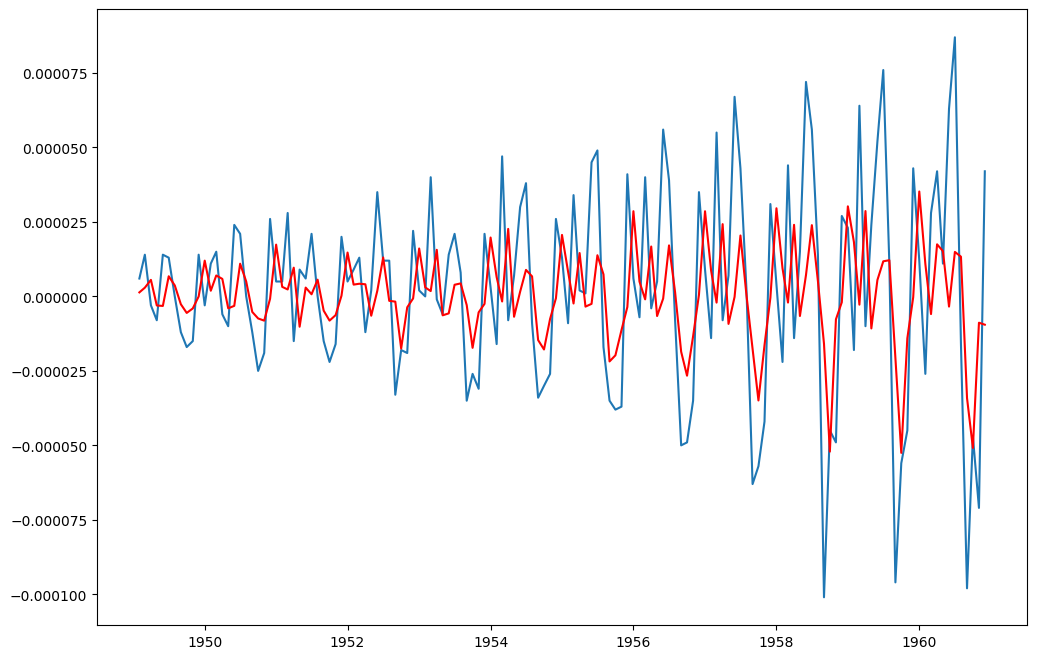

In [317]:
# Call figure() and plot() on the plt
plt.figure(figsize=(12,8))
plt.plot(dif_log_y)
plt.plot(model_arima_211_fit.predict(), color = 'red');

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

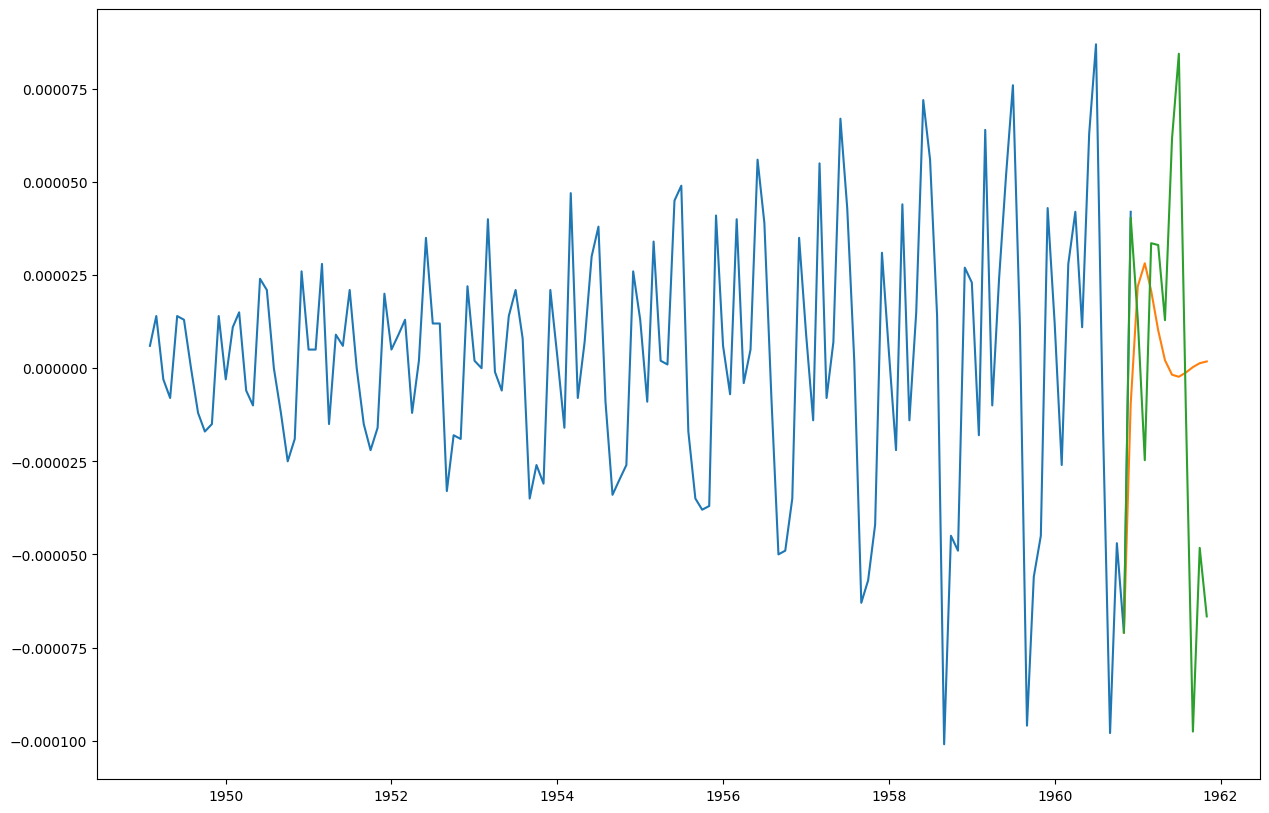

In [325]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 12
date_range = pd.date_range(log_y.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast
future_months['Prediction_sarima'] = forecast_sarima

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(dif_log_y)
plt.plot(dif_log_y['Nov 1960'].append(future_months['Prediction']))
plt.plot(dif_log_y['Nov 1960'].append(future_months['Prediction_sarima']))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

While ARIMA does a good job fitting the dataset due to strong seasonality the SARIMA is the best model for this data set.